# Telecom Churn Prediction

# Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

#### Below steps will be folowed for evaluation
1. Loading dependencies & datasets

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [63]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [1]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, f1_score, accuracy_score
from sklearn import metrics
#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Class Imbalance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

### Derived attribute related functions

In [2]:
#The above data is with respect to data recharge
# We can create new column indicating data recharge and substitute null columns with 0 value


def create_data_rechange_info(df):
    df['data_rechange_6'] = df['date_of_last_rech_data_6'].isnull()
    df['data_rechange_7'] = df['date_of_last_rech_data_7'].isnull()
    df['data_rechange_8'] = df['date_of_last_rech_data_8'].isnull()

    del df['date_of_last_rech_data_6']
    del df['date_of_last_rech_data_7']
    del df['date_of_last_rech_data_8']

    df_len = len(df)*0.7
    i=0
    for col in df.columns:
        if df[col].isnull().sum() >= df_len:
            df[col].fillna(0)
    return df

def create_last_rechange_days(df):
    df['last_recharge_days'] = (pd.to_datetime('2014-08-31') - df[['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']].apply(pd.to_datetime).max(axis=1)).dt.days
    del df['date_of_last_rech_6']
    del df['date_of_last_rech_7']
    del df['date_of_last_rech_8']
    return df

def create_new_variables(df):
    df = create_data_rechange_info(df)
    df = create_last_rechange_days(df)
    return df

## Set display limits
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [3]:
#COMMENT THIS SECTION INCASE RUNNING THIS NOTEBOOK LOCALLY

#Checking the kaggle paths for the uploaded datasets
#import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
#INCASE RUNNING THIS LOCALLY, PASS THE RELATIVE PATH OF THE CSV FILES BELOW
#(e.g. if files are in same folder as notebook, simple write "train.csv" as path)

data = pd.read_csv("/kaggle/input/telecom-churn-case-study-hackathon-c53/train.csv")
unseen = pd.read_csv("/kaggle/input/telecom-churn-case-study-hackathon-c53/test.csv")
sample = pd.read_csv("/kaggle/input/telecom-churn-case-study-hackathon-c53/sample.csv")
data_dict = pd.read_csv("/kaggle/input/telecom-churn-case-study-hackathon-c53/data_dictionary.csv")

#data = pd.read_csv("train.csv")
#unseen = pd.read_csv("test.csv")
#sample = pd.read_csv("sample.csv")
#data_dict = pd.read_csv("data_dictionary.csv")


print('Train data shape - ',data.shape)
print('Test data shape - ',unseen.shape)
print('Sample data shape - ',sample.shape)
print('Data dictionary shape - ', data_dict.shape)

Train data shape -  (69999, 172)
Test data shape -  (30000, 171)
Sample data shape -  (30000, 2)
Data dictionary shape -  (36, 2)


In [5]:
data.describe()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.0,69297.0,69297.0,69297.0,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,...,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,69999.000000,69999.000000,69999.000000,69999.00000,69999.000000
mean,34999.000000,109.0,0.0,0.0,0.0,283.134365,278.185912,278.858826,133.153275,133.894438,...,0.081444,0.085487,0.916325,0.909544,0.890319,1220.639709,68.108597,65.935830,60.07674,0.101887
std,20207.115084,0.0,0.0,0.0,0.0,334.213918,344.366927,351.924315,299.963093,311.277193,...,0.634547,0.680035,0.276907,0.286842,0.312501,952.426321,269.328659,267.899034,257.22681,0.302502
min,0.000000,109.0,0.0,0.0,0.0,-2258.709000,-1289.715000,-945.808000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.00000,0.000000
25%,17499.500000,109.0,0.0,0.0,0.0,93.581000,86.714000,84.095000,7.410000,6.675000,...,0.000000,0.000000,1.000000,1.000000,1.000000,468.000000,0.000000,0.000000,0.00000,0.000000
50%,34999.000000,109.0,0.0,0.0,0.0,197.484000,191.588000,192.234000,34.110000,32.280000,...,0.000000,0.000000,1.000000,1.000000,1.000000,868.000000,0.000000,0.000000,0.00000,0.000000
75%,52498.500000,109.0,0.0,0.0,0.0,370.791000,365.369500,369.909000,119.390000,115.837500,...,0.000000,0.000000,1.000000,1.000000,1.000000,1813.000000,0.000000,0.000000,0.00000,0.000000
max,69998.000000,109.0,0.0,0.0,0.0,27731.088000,35145.834000,33543.624000,7376.710000,8157.780000,...,33.000000,41.000000,1.000000,1.000000,1.000000,4337.000000,12916.220000,9165.600000,11166.21000,1.000000


### Check data type of columns

In [6]:
data.info()
# data type are correctly assigned

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 172 entries, id to churn_probability
dtypes: float64(135), int64(28), object(9)
memory usage: 91.9+ MB


### Columns with NULL value

In [7]:
## Columns with Null values
filtered_data = data.loc[:, data.isnull().sum() != 0]
filtered_data.isnull().sum()

loc_og_t2o_mou            702
std_og_t2o_mou            702
loc_ic_t2o_mou            702
last_date_of_month_7      399
last_date_of_month_8      733
                        ...  
night_pck_user_7        52134
night_pck_user_8        51582
fb_user_6               52431
fb_user_7               52134
fb_user_8               51582
Length: 125, dtype: int64

## 2. Data cleaning and formatting

### Delete columns with only one value

In [8]:
df_len = len(data)*0.9
i=0
for col in data.columns:
    if len(data[col].value_counts()) == 1:
        print(data[col].value_counts())

circle_id
109    69999
Name: count, dtype: int64
loc_og_t2o_mou
0.0    69297
Name: count, dtype: int64
std_og_t2o_mou
0.0    69297
Name: count, dtype: int64
loc_ic_t2o_mou
0.0    69297
Name: count, dtype: int64
last_date_of_month_6
6/30/2014    69999
Name: count, dtype: int64
last_date_of_month_7
7/31/2014    69600
Name: count, dtype: int64
last_date_of_month_8
8/31/2014    69266
Name: count, dtype: int64
std_og_t2c_mou_6
0.0    67231
Name: count, dtype: int64
std_og_t2c_mou_7
0.0    67312
Name: count, dtype: int64
std_og_t2c_mou_8
0.0    66296
Name: count, dtype: int64
std_ic_t2o_mou_6
0.0    67231
Name: count, dtype: int64
std_ic_t2o_mou_7
0.0    67312
Name: count, dtype: int64
std_ic_t2o_mou_8
0.0    66296
Name: count, dtype: int64


In [9]:
pd.set_option('display.max_columns', None)

In [10]:
df_len = len(data)*0.9
i=0
for col in data.columns:
    if len(data[col].value_counts()) == 1:
        i=i+1
        print(i,'.', col,'.',data[col][0],'.',round(data[col].value_counts().iloc[0]*100/len(data),2),'%')
        del data[col]

1 . circle_id . 109 . 100.0 %
2 . loc_og_t2o_mou . 0.0 . 99.0 %
3 . std_og_t2o_mou . 0.0 . 99.0 %
4 . loc_ic_t2o_mou . 0.0 . 99.0 %
5 . last_date_of_month_6 . 6/30/2014 . 100.0 %
6 . last_date_of_month_7 . 7/31/2014 . 99.43 %
7 . last_date_of_month_8 . 8/31/2014 . 98.95 %
8 . std_og_t2c_mou_6 . 0.0 . 96.05 %
9 . std_og_t2c_mou_7 . 0.0 . 96.16 %
10 . std_og_t2c_mou_8 . 0.0 . 94.71 %
11 . std_ic_t2o_mou_6 . 0.0 . 96.05 %
12 . std_ic_t2o_mou_7 . 0.0 . 96.16 %
13 . std_ic_t2o_mou_8 . 0.0 . 94.71 %


### Delete columns with more than 90% same values

In [11]:
df_len = len(data)*0.9
i=0
l = []
for col in data.columns:
    if data[col].value_counts().iloc[0] >= df_len:
        i=i+1
        print(i,'.', col,'.',data[col].value_counts().iloc[0],'.',round(data[col].value_counts().iloc[0]*100/len(data),2),'%')
        del data[col]

1 . isd_og_mou_6 . 63897 . 91.28 %
2 . isd_og_mou_7 . 64180 . 91.69 %
3 . isd_og_mou_8 . 63384 . 90.55 %
4 . og_others_7 . 67072 . 95.82 %
5 . og_others_8 . 65996 . 94.28 %
6 . monthly_2g_6 . 64896 . 92.71 %
7 . monthly_2g_7 . 64695 . 92.42 %
8 . monthly_2g_8 . 64817 . 92.6 %
9 . monthly_3g_6 . 65990 . 94.27 %
10 . monthly_3g_7 . 66062 . 94.38 %
11 . monthly_3g_8 . 65789 . 93.99 %
12 . sachet_3g_6 . 67088 . 95.84 %
13 . sachet_3g_7 . 67101 . 95.86 %
14 . sachet_3g_8 . 67059 . 95.8 %


### Removing columns with more than 70 % null values

In [12]:
df_len = len(data)*0.7
i=0
print('Columns with more than 70% missing values')
for col in data.columns:
    if data[col].isnull().sum() >= df_len:
        i=i+1
        print(i,'.', col,'.',data[col].isnull().sum(),'.', round((data[col].isnull().sum()/len(data))*100,2))
        #del data[col]

Columns with more than 70% missing values
1 . date_of_last_rech_data_6 . 52431 . 74.9
2 . date_of_last_rech_data_7 . 52134 . 74.48
3 . date_of_last_rech_data_8 . 51582 . 73.69
4 . total_rech_data_6 . 52431 . 74.9
5 . total_rech_data_7 . 52134 . 74.48
6 . total_rech_data_8 . 51582 . 73.69
7 . max_rech_data_6 . 52431 . 74.9
8 . max_rech_data_7 . 52134 . 74.48
9 . max_rech_data_8 . 51582 . 73.69
10 . count_rech_2g_6 . 52431 . 74.9
11 . count_rech_2g_7 . 52134 . 74.48
12 . count_rech_2g_8 . 51582 . 73.69
13 . count_rech_3g_6 . 52431 . 74.9
14 . count_rech_3g_7 . 52134 . 74.48
15 . count_rech_3g_8 . 51582 . 73.69
16 . av_rech_amt_data_6 . 52431 . 74.9
17 . av_rech_amt_data_7 . 52134 . 74.48
18 . av_rech_amt_data_8 . 51582 . 73.69
19 . arpu_3g_6 . 52431 . 74.9
20 . arpu_3g_7 . 52134 . 74.48
21 . arpu_3g_8 . 51582 . 73.69
22 . arpu_2g_6 . 52431 . 74.9
23 . arpu_2g_7 . 52134 . 74.48
24 . arpu_2g_8 . 51582 . 73.69
25 . night_pck_user_6 . 52431 . 74.9
26 . night_pck_user_7 . 52134 . 74.48
27 . n

#### <span style="color:blue">Observation :-</span>
Since same count of data for rechange related columns are missing, hence will not delete it.
Will handle in derived data section.
Create new attribute to indicate has data recharge or not and consider default value for NA cell as Zero.

In [13]:
data = create_data_rechange_info(data)
unseen = create_data_rechange_info(unseen)

### Removing columns not required for analysis

In [14]:
del data['id'] # primary key

### Removing rows with all null values in July, Aug, Sept

In [15]:
# Get all unique prefixes from column names
prefixes = set('_'.join(col.split('_')[0:-1]) for col in data.columns if col.split('_')[-1] in ['6','7','8'])
# Create a list to store filtered DataFrames for each prefix
filtered_dfs = []
print('Shape before row delete - ', data.shape)
# Iterate over prefixes and filter rows where all columns with the same prefix are null
for prefix in prefixes:
    # Get columns with the current prefix
    cols_with_prefix = [col for col in data.columns if col.startswith(prefix)]
    
    # Filter rows where all columns with the same prefix are null
    filtered_df = data[data[cols_with_prefix].isnull().all(axis=1)]
    if len(filtered_df) > 0:
        print(prefix,'_*', ' count - ', len(filtered_df))
    # Append the filtered DataFrame to the list
    data = data[~data[cols_with_prefix].isnull().all(axis=1)]
    
print('Shape after row delete - ', data.shape)

Shape before row delete -  (69999, 144)
av_rech_amt_data _*  count -  43876
std_ic_t2f_mou _*  count -  360
og_others _*  count -  683
Shape after row delete -  (25080, 144)


### Check for duplicates

In [16]:
data[data.duplicated()]

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,data_rechange_6,data_rechange_7,data_rechange_8


### Filter High Value customer
 - Those who have recharged with an amount more than or equal 70th percentile of the average recharge amount in the first two months (the good phase)

In [17]:
#Deriving Average recharge amount of June and July.

#Training data
data['Average_rech_amt_6n7']=(data['total_rech_amt_6']+data['total_rech_amt_7'])/2

#Unseen data
unseen['Average_rech_amt_6n7']=(unseen['total_rech_amt_6']+unseen['total_rech_amt_7'])/2

In [18]:
#Filtering based HIGH VALUED CUSTOMERS based on (Average_rech_amt_6n7 >= 70th percentile of Average_rech_amt_6n7)
data=data[(data['Average_rech_amt_6n7']>= data['Average_rech_amt_6n7'].quantile(0.7))]

#Unseen
#We will not filter unseen data

### Add default value 0 to numerical values

In [19]:
for col in data.select_dtypes(include=['float']):
    data[col] = data[col].fillna(0)

In [20]:
filtered_data = data.loc[:, data.isnull().sum() != 0]
filtered_data.isnull().sum()

date_of_last_rech_6     2
date_of_last_rech_7     5
date_of_last_rech_8    87
dtype: int64

### Derived attributes

In [21]:
df_len = len(data)*0.7
i=0
print('Columns with more than 50% missing values deleted')
for col in data.columns:
    if data[col].isnull().sum() >= df_len:
        i=i+1
        print(i,'.', col,'.',data[col].isnull().sum(),'.', round((data[col].isnull().sum()/len(data))*100,2))

Columns with more than 50% missing values deleted


#### <span style="color:blue">Observation :-</span>
The value in above columns is only for data rechange related columns
So we can create a column to depict data recharge and fill null numerical values with 0 instead of NA

### derive last recharge in days from dates

In [22]:
data = create_last_rechange_days(data)
unseen = create_last_rechange_days(unseen)

In [23]:
## Columns with Null values
filtered_data = data.loc[:, data.isnull().sum() != 0]
filtered_data.isnull().sum()

Series([], dtype: float64)

In [24]:
pd.set_option('display.max_rows', None)

In [25]:
data[data['onnet_mou_8'].isnull()]['churn_probability'].value_counts()

Series([], Name: count, dtype: int64)

In [26]:
data['churn_probability'].value_counts()

churn_probability
0    7041
1     491
Name: count, dtype: int64

## 3. Exploratory Data analysis 

### Univariant analysis

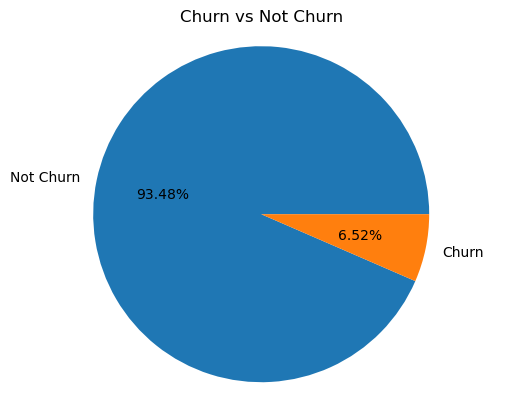

In [27]:
plt.pie(data['churn_probability'].value_counts().values,labels=['Not Churn','Churn'], autopct='%.2f%%')
plt.axis('equal')
plt.title('Churn vs Not Churn')
plt.show()

> <span style="color:blue">Observation</span> - Only 10% of data has churn related information hence class imbalance handling techniques to be used

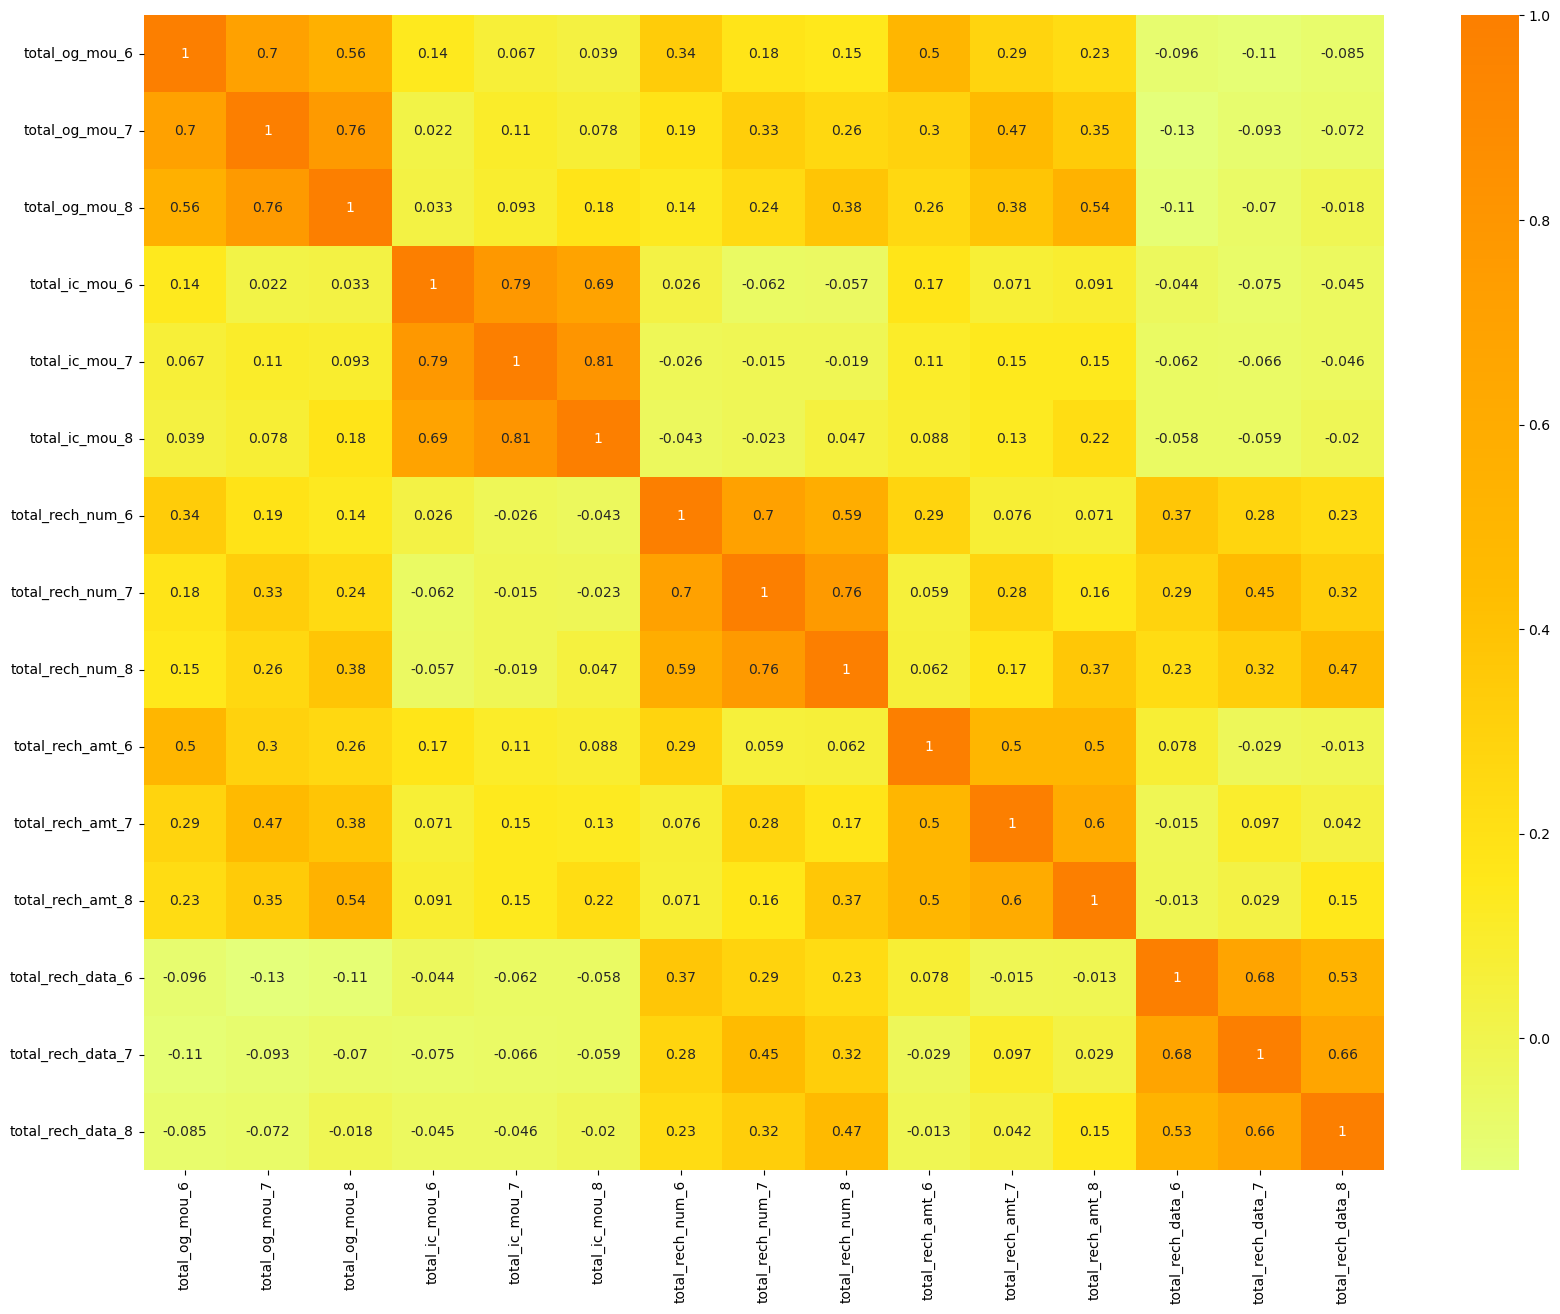

In [28]:
# Get all unique prefixes from column names
month_columns = list(col for col in data.columns if 'total' in col)

# figure size
plt.figure(figsize=(20, 15))

# heatmap
sns.heatmap(data[month_columns].corr(), cmap="Wistia", annot=True)
plt.show()

### Drop month related columns which are highly correlated with total

In [29]:
correlation_matrix = data.corr()

# Set the correlation threshold (adjust as needed)
correlation_threshold = 0.7
total_columns = set(col for col in data.columns if 'total' in col)
month_columns = set(col for col in data.columns if 'total' not in col and col.split('_')[-1] in ['6','7','8'])

# Find columns with high correlation
highly_correlated_columns = set()
for i in total_columns:
    for j in month_columns:
        if abs(correlation_matrix[i][j]) > correlation_threshold:
            print(j," --- ",correlation_matrix[i][j])
            highly_correlated_columns.add(j)

# 'highly_correlated_columns' now contains the names of columns with high correlation
print(highly_correlated_columns)

data.drop(columns=highly_correlated_columns, inplace=True)

loc_ic_mou_7  ---  0.727257321405752
loc_ic_t2m_mou_8  ---  0.7582337065246461
loc_ic_mou_8  ---  0.8864418026426568
offnet_mou_6  ---  0.7202073397342664
std_og_mou_6  ---  0.7928837088292023
loc_ic_mou_7  ---  0.8786646099716479
loc_ic_t2m_mou_7  ---  0.7532606923618284
loc_ic_mou_8  ---  0.723622094973335
arpu_8  ---  0.9564504181262066
count_rech_2g_7  ---  0.8353406640441396
sachet_2g_7  ---  0.8348829509800051
std_og_mou_8  ---  0.8087920787033189
onnet_mou_8  ---  0.7581672109664666
loc_ic_mou_7  ---  0.7316447253137409
loc_ic_mou_6  ---  0.9005842315574941
loc_ic_t2m_mou_6  ---  0.7831908667276534
sachet_2g_6  ---  0.8292146090855438
count_rech_2g_6  ---  0.8323916775701876
arpu_7  ---  0.9360212193019155
std_og_mou_7  ---  0.8131105020421765
onnet_mou_7  ---  0.7196835840944523
arpu_6  ---  0.9428078167560686
sachet_2g_8  ---  0.8286651285993967
count_rech_2g_8  ---  0.8291498286618134
{'onnet_mou_7', 'loc_ic_t2m_mou_7', 'offnet_mou_6', 'loc_ic_t2m_mou_8', 'count_rech_2g_6', '

### Drop month related columns which are highly correlated

correlation_matrix = data.corr()

# Set the correlation threshold (adjust as needed)
correlation_threshold = 0.8
month_columns = set(col for col in data.columns if 'total' not in col and col.split('_')[-1] in ['6','7','8'])

# Find columns with high correlation
highly_correlated_columns = set()
for i in month_columns:
    for j in month_columns:
        if abs(correlation_matrix[i][j]) > correlation_threshold and i!=j:
            highly_correlated_columns.add(j)

# 'highly_correlated_columns' now contains the names of columns with high correlation
print(highly_correlated_columns)

data.drop(columns=highly_correlated_columns, inplace=True)

correlation_matrix = data.corr()

# Set the correlation threshold (adjust as needed)
correlation_threshold = 0.80
month_columns = set(col for col in data.columns if 'total' not in col and col.split('_')[-1] in ['6','7','8'])

# Find columns with high correlation
highly_correlated_columns = set()
for i in data.columns:
    for j in data.columns:
        if abs(correlation_matrix[i][j]) > correlation_threshold and i!=j:
            print(j," --- ",correlation_matrix[i][j])
            highly_correlated_columns.add(j)

# 'highly_correlated_columns' now contains the names of columns with high correlation
print(highly_correlated_columns)

data.drop(columns=highly_correlated_columns, inplace=True)

In [30]:
data.columns

Index(['onnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6',
       'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7',
       'roam_og_mou_8', 'loc_og_t2t_mou_6',
       ...
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'churn_probability',
       'data_rechange_6', 'data_rechange_7', 'data_rechange_8',
       'Average_rech_amt_6n7', 'last_recharge_days'],
      dtype='object', length=122)

In [31]:
data_dict

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belo...
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls
5,T2T,Operator T to T ie within same operator mobile...
6,T2M,Operator T to other operator mobile
7,T2O,Operator T to other operator fixed line
8,T2F,Operator T to fixed lines of T
9,T2C,Operator T to its own call center


For the purpose of this **starter notebook**, we I will restrict the dataset to only a small set of variables. 

The approach I use here is to understand each Acronym, figure our what variable might be important and filter out variable names based on the combinations of acrynoms using REGEX. So, if I want the total minutes a person has spent on outgoing calls, I need acronyms, TOTAL, OG and MOU. So corresponding regex is ```total.+og.+mou```

In [32]:
data.head()

,onnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,data_rechange_6,data_rechange_7,data_rechange_8,Average_rech_amt_6n7,last_recharge_days
15,10.43,341.79,197.09,0.00,0.00,0.0,0.00,0.00,0.0,10.43,24.99,194.43,313.76,330.88,185.88,3.26,10.91,4.94,0.00,0.00,0.00,327.46,366.79,385.26,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,6.26,0.08,0.00,0.00,0.10,327.64,366.79,391.53,13.86,20.18,335.43,0.00,1.93,8.88,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.03,0.0,0.00,1.03,0.00,233.18,777.39,629.94,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,5,3,4,654,400,652,250,250,250,0,150,250,1.0,0.0,1.0,154.0,0.0,154.0,0.0,0.0,0.0,154.0,0.0,154.0,260.42,0.00,354.35,0.00,0.00,0.00,0.00,0.00,0.00,164.75,0.00,28.80,0.0,0.0,0.0,1.0,0.0,1.0,602,0.00,0.00,0.00,0,False,True,False,527.0,1
27,8.58,158.73,182.83,0.00,0.00,0.0,0.00,0.00,0.0,8.58,11.48,12.68,96.91,149.44,157.23,33.71,9.28,25.59,0.00,0.00,0.00,139.21,170.21,195.51,0.00,0.00,0.00,2.53,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,141.74,170.21,195.51,51.74,83.83,82.81,87.28,67.69,107.94,0.00,0.00,0.40,0.00,0.00,0.00,15.43,0.00,0.0,15.43,0.00,0.40,283.48,366.03,350.86,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,13,8,4,565,572,250,154,200,164,110,200,61,4.0,2.0,3.0,154.0,152.0,164.0,0.0,1.0,2.0,205.0,304.0,214.0,5.99,92.93,10.54,374.70,275.38,1342.93,79.35,86.55,161.92,0.18,69.20,161.92,0.0,0.0,0.0,1.0,1.0,1.0,573,700.40,185.71,173.72,0,False,False,False,568.5,8
39,64.66,339.28,558.59,0.00,0.00,0.0,0.00,0.00,0.0,1.60,13.66,20.94,0.43,38.58,12.91,0.00,0.00,0.00,0.00,0.00,0.00,2.03,52.24,33.86,63.06,585.08,544.71,36.43,287.23,545.68,0.0,0.0,0.00,0.96,13.46,0.00,0.00,102.49,938.03,1124.26,1.73,5.69,7.84,0.00,0.00,4.85,156.98,93.06,173.33,90.18,86.06,73.61,0.00,0.00,0.0,247.16,179.13,246.94,257.33,197.48,310.29,0.0,0.0,0.0,0.0,0.00,40.54,0.0,0.0,0.0,4,14,16,448,716,1127,154,154,252,110,50,0,2.0,1.0,2.0,154.0,154.0,252.0,0.0,0.0,1.0,308.0,154.0,427.0,1884.40,1312.21,1476.89,0.00,0.00,0.00,0.00,0.00,212.17,0.01,0.00,250.42,0.0,0.0,0.0,1.0,1.0,1.0,622,0.00,0.00,0.00,0,False,False,False,582.0,1
45,872.16,420.19,225.53,8.83,149.04,0.0,6.43,388.73,0.0,75.24,62.19,69.71,167.34,162.36,165.78,0.00,2.35,1.18,2.44,0.25,0.18,242.59,226.91,236.68,791.49,221.51,1009.21,232.68,99.08,28.79,0.0,0.0,0.00,17.49,36.41,33.16,3.78,1288.06,583.93,1307.86,36.96,128.29,69.49,0.00,1.60,0.66,

Let's look at each variable's datatype:

In [33]:
data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Index: 7532 entries, 15 to 69984
Data columns (total 122 columns):
 #    Column                Dtype  
---   ------                -----  
 0    onnet_mou_6           float64
 1    offnet_mou_7          float64
 2    offnet_mou_8          float64
 3    roam_ic_mou_6         float64
 4    roam_ic_mou_7         float64
 5    roam_ic_mou_8         float64
 6    roam_og_mou_6         float64
 7    roam_og_mou_7         float64
 8    roam_og_mou_8         float64
 9    loc_og_t2t_mou_6      float64
 10   loc_og_t2t_mou_7      float64
 11   loc_og_t2t_mou_8      float64
 12   loc_og_t2m_mou_6      float64
 13   loc_og_t2m_mou_7      float64
 14   loc_og_t2m_mou_8      float64
 15   loc_og_t2f_mou_6      float64
 16   loc_og_t2f_mou_7      float64
 17   loc_og_t2f_mou_8      float64
 18   loc_og_t2c_mou_6      float64
 19   loc_og_t2c_mou_7      float64
 20   loc_og_t2c_mou_8      float64
 21   loc_og_mou_6          float64
 22   loc_og_mou_7          flo

Let's also summarize the features using the df.describe method:

In [34]:
data.describe(include="all")

,onnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,data_rechange_6,data_rechange_7,data_rechange_8,Average_rech_amt_6n7,last_recharge_days
count,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.00000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.00000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532.000000,7532,7532,7532,7532.000000,7532.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [35]:
# deriving columns with respect to service usage based on location
column=data.columns
all_loc_mou=[]
for c in column:
  if c.startswith("loc"):
    all_loc_mou.append(c)
  else:
    pass

all_loc_mou

['loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2t_mou_7',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2f_mou_6',
 'loc_ic_t2f_mou_7',
 'loc_ic_t2f_mou_8']

In [36]:
# mou for all loc calls
data['total_loc_mou'] = data[all_loc_mou].sum(axis=1)
data['total_loc_mou'].head()

15    2539.27
27    1491.12
39     196.36
45    1652.20
53    3050.60
Name: total_loc_mou, dtype: float64

In [37]:
# deriving columns with respect to service usage based on standard call
all_std_mou=[]
for c in column:
  if c.startswith('std'):
    all_std_mou.append(c)
  else:
    pass

all_std_mou

['std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_ic_t2t_mou_6',
 'std_ic_t2t_mou_7',
 'std_ic_t2t_mou_8',
 'std_ic_t2m_mou_6',
 'std_ic_t2m_mou_7',
 'std_ic_t2m_mou_8',
 'std_ic_t2f_mou_6',
 'std_ic_t2f_mou_7',
 'std_ic_t2f_mou_8',
 'std_ic_mou_6',
 'std_ic_mou_7',
 'std_ic_mou_8']

In [38]:
# Creating the mou for all std calls
data['total_std_mou'] = data[all_std_mou].sum(axis=1)
data['total_std_mou'].head()

15       8.32
27      34.19
39    3408.64
45    2886.30
53      88.03
Name: total_std_mou, dtype: float64

In [39]:
# selecting columns based on isd calls in month 6,7,8
all_isd_mou=[]
for c in column:
  if c.startswith('isd'):
    all_isd_mou.append(c)
  else:
    pass

all_isd_mou

['isd_ic_mou_6', 'isd_ic_mou_7', 'isd_ic_mou_8']

In [40]:
# Creating the mou for all isd calls
data['total_isd_mou'] = data[all_isd_mou].sum(axis=1)
data['total_isd_mou'].head()

15     0.00
27     0.00
39    40.54
45     0.00
53     0.11
Name: total_isd_mou, dtype: float64

In [41]:
data['total_rech_amt_6'].describe(include="all")

count     7532.000000
mean       861.288237
std        537.734352
min          0.000000
25%        555.000000
50%        740.000000
75%       1030.000000
max      17840.000000
Name: total_rech_amt_6, dtype: float64

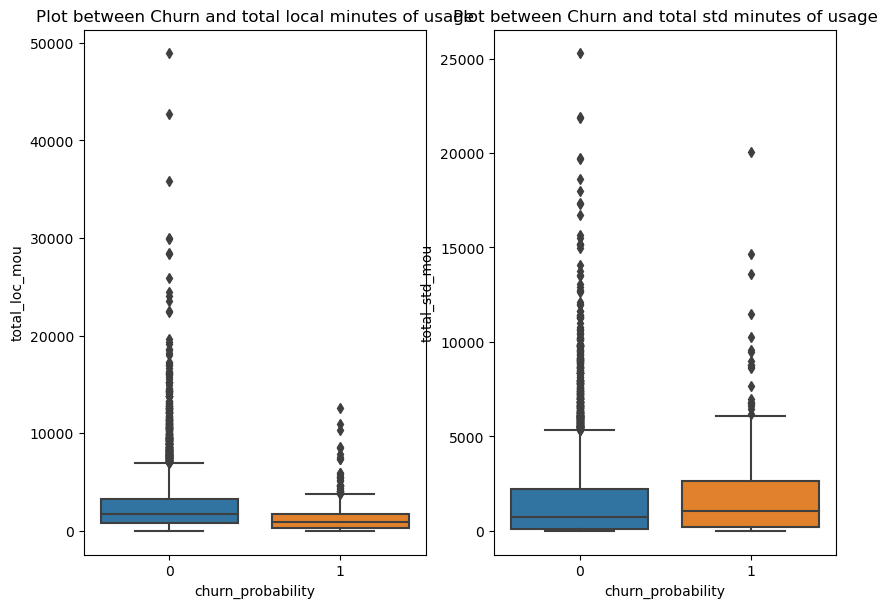

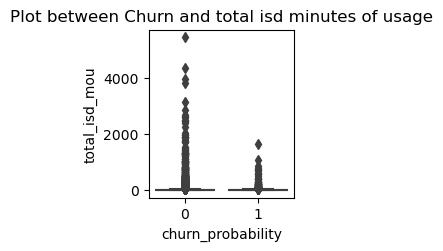

In [42]:
# Visualizing the churn variable with various predictor variables

#Plotting different varaible against churn
plt.figure(figsize=(15, 15))
plt.subplot(2,3,1)
sns.boxplot(x = 'churn_probability', y = 'total_loc_mou', data = data)
plt.title("Plot between Churn and total local minutes of usage")
plt.subplot(2,3,2)
sns.boxplot(x = 'churn_probability', y = 'total_std_mou', data = data)
plt.title("Plot between Churn and total std minutes of usage")
plt.show()
plt.subplot(2,3,3)
sns.boxplot(x = 'churn_probability', y = 'total_isd_mou', data = data)
plt.title("Plot between Churn and total isd minutes of usage")
plt.show()

#### <span style="color:blue">Observation :-</span>
As the number of minutes LOCAL,STD and ISD increases, the churn rate decreases clearly.
    

					Distribution of total_rech_data_6 variable
 total_rech_amt_group_6
>500_Recharges        1026
>200-300_Recharges     145
100-200_Recharges       64
No_Recharge             34
<=100_Recharges         28
Name: count, dtype: int64


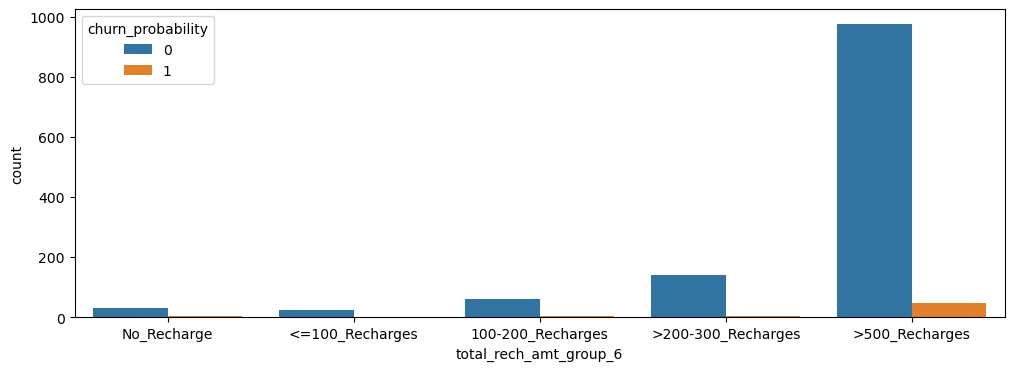

					Distribution of total_rech_amt_group_7 variable
 total_rech_amt_group_7
>500_Recharges        1014
>200-300_Recharges     156
No_Recharge             70
100-200_Recharges       46
<=100_Recharges         34
Name: count, dtype: int64


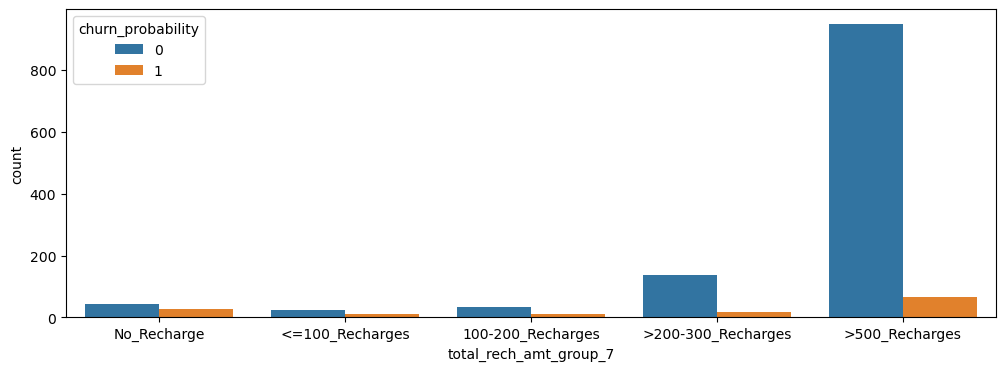

					Distribution of total_rech_amt_group_8 variable
 total_rech_amt_group_8
>500_Recharges        1266
>200-300_Recharges     409
No_Recharge            325
100-200_Recharges      248
<=100_Recharges        171
Name: count, dtype: int64


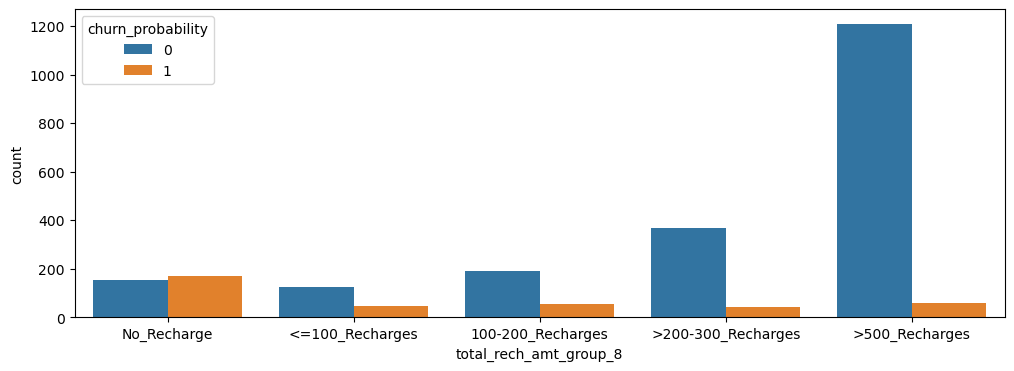

In [43]:


data['total_rech_amt_group_6']=pd.cut(data['total_rech_amt_6'],[-1,0,100,200,300,500],labels=["No_Recharge","<=100_Recharges","100-200_Recharges",">200-300_Recharges",">500_Recharges"])
data['total_rech_amt_group_7']=pd.cut(data['total_rech_amt_7'],[-1,0,100,200,300,500],labels=["No_Recharge","<=100_Recharges","100-200_Recharges",">200-300_Recharges",">500_Recharges"])
data['total_rech_amt_group_8']=pd.cut(data['total_rech_amt_8'],[-1,0,100,200,300,500],labels=["No_Recharge","<=100_Recharges","100-200_Recharges",">200-300_Recharges",">500_Recharges"])


plt.figure(figsize=[12,4])
sns.countplot(data=data,x="total_rech_amt_group_6",hue="churn_probability")
print("\t\t\t\t\tDistribution of total_rech_data_6 variable\n",data['total_rech_amt_group_6'].value_counts())
plt.show()

plt.figure(figsize=[12,4])
sns.countplot(data=data,x="total_rech_amt_group_7",hue="churn_probability")
print("\t\t\t\t\tDistribution of total_rech_amt_group_7 variable\n",data['total_rech_amt_group_7'].value_counts())
plt.show()

plt.figure(figsize=[12,4])
sns.countplot(data=data,x="total_rech_amt_group_8",hue="churn_probability")
print("\t\t\t\t\tDistribution of total_rech_amt_group_8 variable\n",data['total_rech_amt_group_8'].value_counts())
plt.show()


#### <span style="color:blue">Observation :-</span>
As the number of recharge amount increases, the churn rate decreases clearly.

In [44]:
def plot_box_chart(attribute):
    plt.figure(figsize=(20,16))
    df = data
    plt.subplot(2,3,1)
    sns.boxplot(data=df, y=attribute+"_6",x="churn_probability",hue="churn_probability",
                showfliers=False,palette=("husl"))
    plt.subplot(2,3,2)
    sns.boxplot(data=df, y=attribute+"_7",x="churn_probability",hue="churn_probability",
                showfliers=False,palette=("husl"))
    plt.subplot(2,3,3)
    sns.boxplot(data=df, y=attribute+"_8",x="churn_probability",hue="churn_probability",
                showfliers=False,palette=("husl"))
    plt.show()

In [45]:
recharge_amnt_columns =  data.columns[data.columns.str.contains('rech_amt')]
recharge_amnt_columns.tolist()

['total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'Average_rech_amt_6n7',
 'total_rech_amt_group_6',
 'total_rech_amt_group_7',
 'total_rech_amt_group_8']

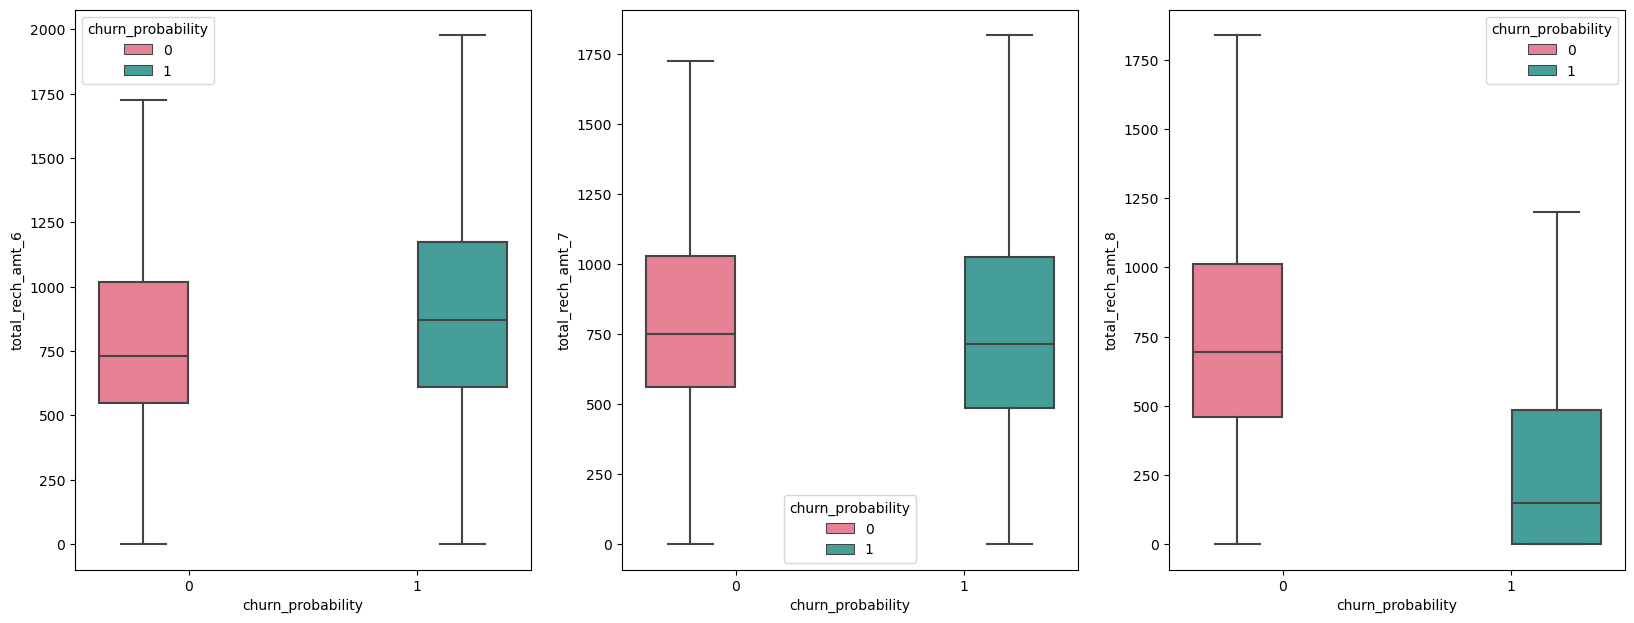

In [46]:
plot_box_chart('total_rech_amt')

#### <span style="color:blue">Observation :-</span> : In the 8th month (Action Phase), we observe a decline in the total recharge amount for customers who have churned.

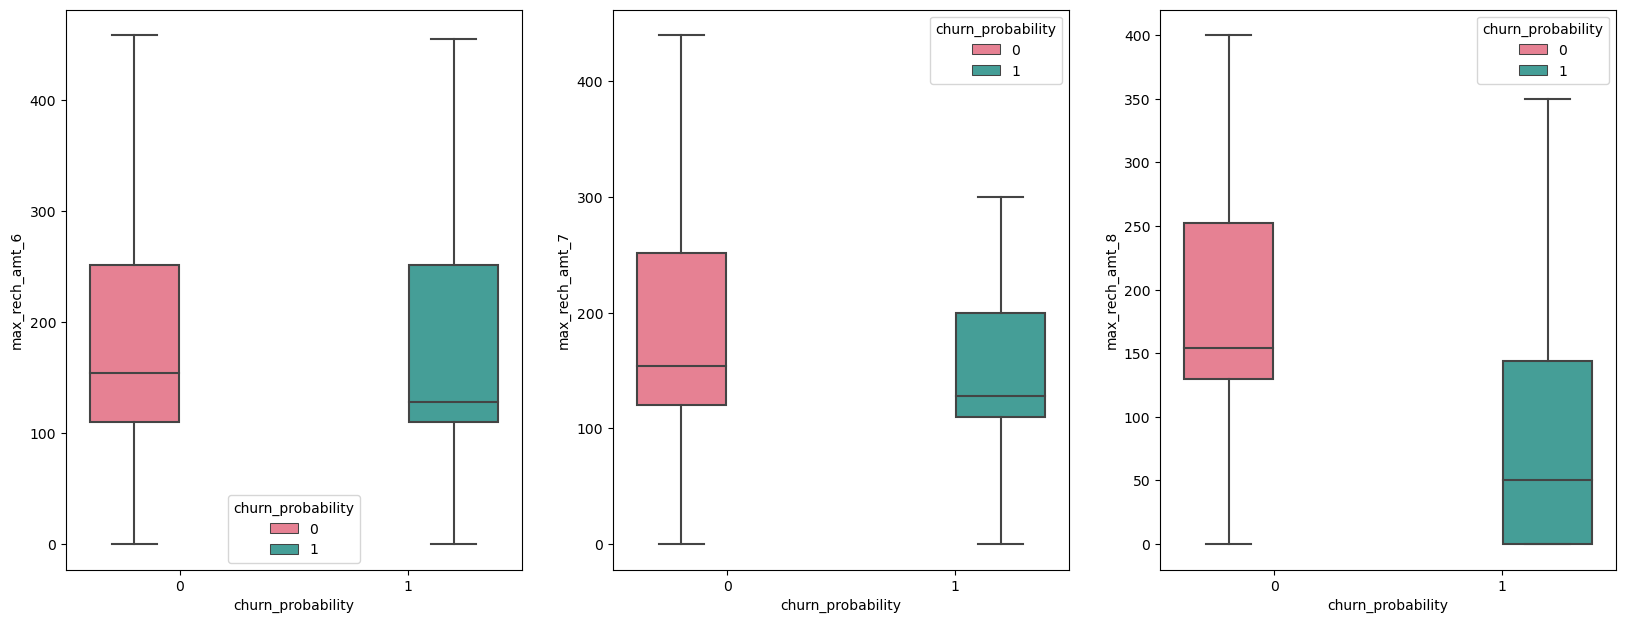

In [47]:
plot_box_chart('max_rech_amt')

#### <span style="color:blue">Observation :-</span> : In the 8th month (Action Phase), we observe a decline in the maximum recharge amount for customers who have churned.

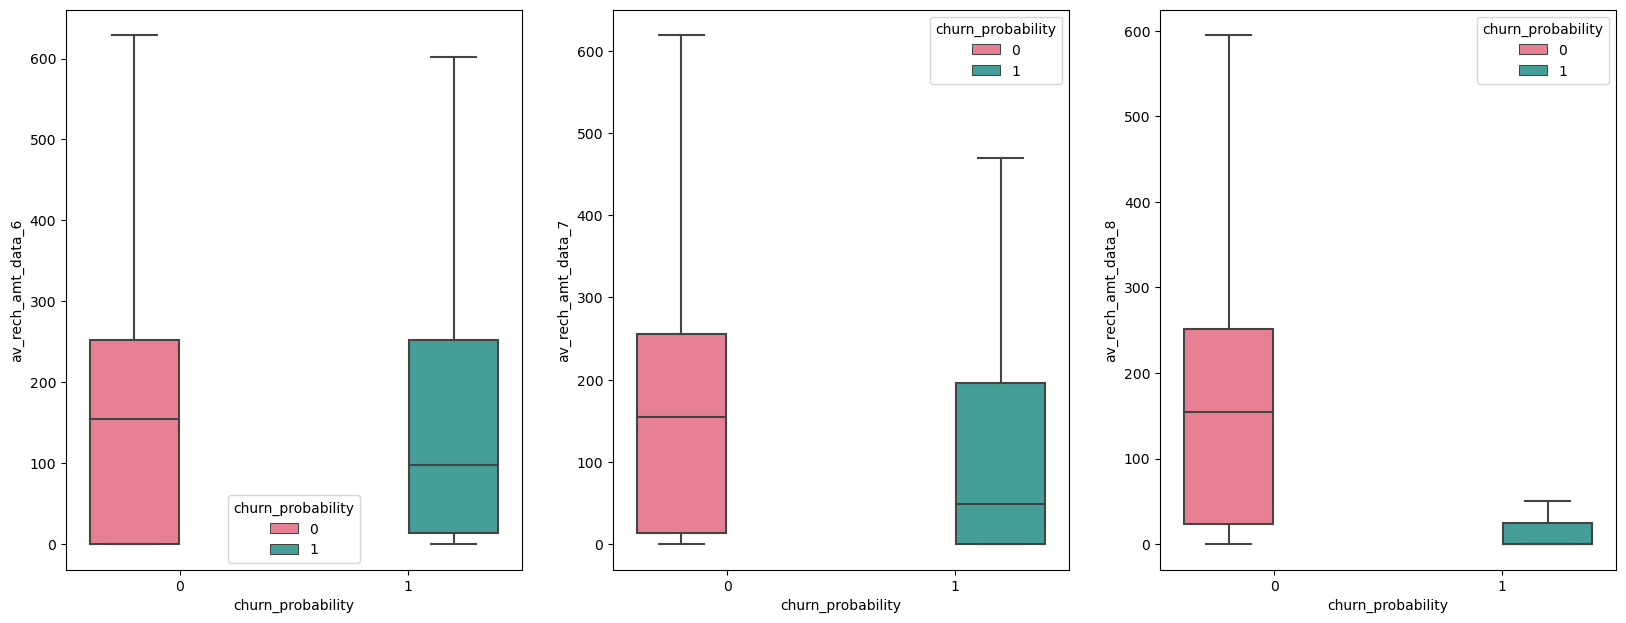

In [48]:
plot_box_chart('av_rech_amt_data')

#### <span style="color:blue">Observation :-</span> : In the 8th month (Action Phase), we observe a decline in the average recharge amount data for customers who have churned.

In [49]:
data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Index: 7532 entries, 15 to 69984
Data columns (total 128 columns):
 #    Column                  Dtype   
---   ------                  -----   
 0    onnet_mou_6             float64 
 1    offnet_mou_7            float64 
 2    offnet_mou_8            float64 
 3    roam_ic_mou_6           float64 
 4    roam_ic_mou_7           float64 
 5    roam_ic_mou_8           float64 
 6    roam_og_mou_6           float64 
 7    roam_og_mou_7           float64 
 8    roam_og_mou_8           float64 
 9    loc_og_t2t_mou_6        float64 
 10   loc_og_t2t_mou_7        float64 
 11   loc_og_t2t_mou_8        float64 
 12   loc_og_t2m_mou_6        float64 
 13   loc_og_t2m_mou_7        float64 
 14   loc_og_t2m_mou_8        float64 
 15   loc_og_t2f_mou_6        float64 
 16   loc_og_t2f_mou_7        float64 
 17   loc_og_t2f_mou_8        float64 
 18   loc_og_t2c_mou_6        float64 
 19   loc_og_t2c_mou_7        float64 
 20   loc_og_t2c_mou_8        float64

In [50]:
data['total_rech_data_group_6']=pd.cut(data['total_rech_data_6'],[-1,0,10,25,100],labels=["No_Recharge","<=10_Recharges","10-25_Recharges",">25_Recharges"])
data['total_rech_data_group_7']=pd.cut(data['total_rech_data_7'],[-1,0,10,25,100],labels=["No_Recharge","<=10_Recharges","10-25_Recharges",">25_Recharges"])
data['total_rech_data_group_8']=pd.cut(data['total_rech_data_8'],[-1,0,10,25,100],labels=["No_Recharge","<=10_Recharges","10-25_Recharges",">25_Recharges"])

data['total_rech_num_group_6']=pd.cut(data['total_rech_num_6'],[-1,0,10,25,1000],labels=["No_Recharge","<=10_Recharges","10-25_Recharges",">25_Recharges"])
data['total_rech_num_group_7']=pd.cut(data['total_rech_num_7'],[-1,0,10,25,1000],labels=["No_Recharge","<=10_Recharges","10-25_Recharges",">25_Recharges"])
data['total_rech_num_group_8']=pd.cut(data['total_rech_num_8'],[-1,0,10,25,1000],labels=["No_Recharge","<=10_Recharges","10-25_Recharges",">25_Recharges"])

data[['total_rech_data_6','total_rech_data_group_6','total_rech_data_7','total_rech_data_group_7','total_rech_data_8','total_rech_data_group_8',
              'total_rech_num_6','total_rech_num_group_6','total_rech_num_7','total_rech_num_group_7','total_rech_num_8','total_rech_num_group_8']].head()


,total_rech_data_6,total_rech_data_group_6,total_rech_data_7,total_rech_data_group_7,total_rech_data_8,total_rech_data_group_8,total_rech_num_6,total_rech_num_group_6,total_rech_num_7,total_rech_num_group_7,total_rech_num_8,total_rech_num_group_8
15,1.0,<=10_Recharges,0.0,No_Recharge,1.0,<=10_Recharges,5,<=10_Recharges,3,<=10_Recharges,4,<=10_Recharges
27,4.0,<=10_Recharges,2.0,<=10_Recharges,3.0,<=10_Recharges,13,10-25_Recharges,8,<=10_Recharges,4,<=10_Recharges
39,2.0,<=10_Recharges,1.0,<=10_Recharges,2.0,<=10_Recharges,4,<=10_Recharges,14,10-25_Recharges,16,10-25_Recharges
45,3.0,<=10_Recharges,5.0,<=10_Recharges,1.0,<=10_Recharges,24,10-25_Recharges,29,>25_Recharges,14,10-25_Recharges
53,2.0,<=10_Recharges,2.0,<=10_Recharges,1.0,<=10_Recharges,9,<=10_Recharges,13,10-25_Recharges,7,<=10_Recharges


					Distribution of total_rech_data_6 variable
 total_rech_data_group_6
<=10_Recharges     5409
No_Recharge        2002
10-25_Recharges     110
>25_Recharges        11
Name: count, dtype: int64


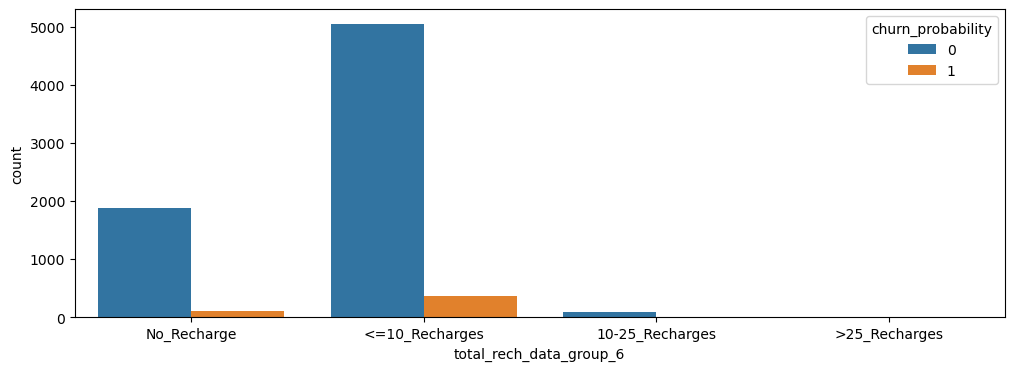




					Distribution of total_rech_data_6 variable
 total_rech_data_group_7
<=10_Recharges     5467
No_Recharge        1906
10-25_Recharges     136
>25_Recharges        23
Name: count, dtype: int64


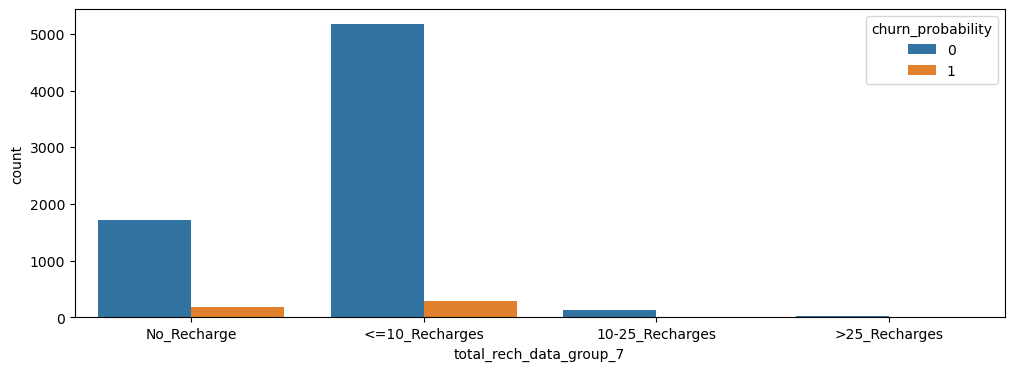


					Distribution of total_rech_data_6 variable
 total_rech_data_group_8
<=10_Recharges     5543
No_Recharge        1856
10-25_Recharges     113
>25_Recharges        20
Name: count, dtype: int64


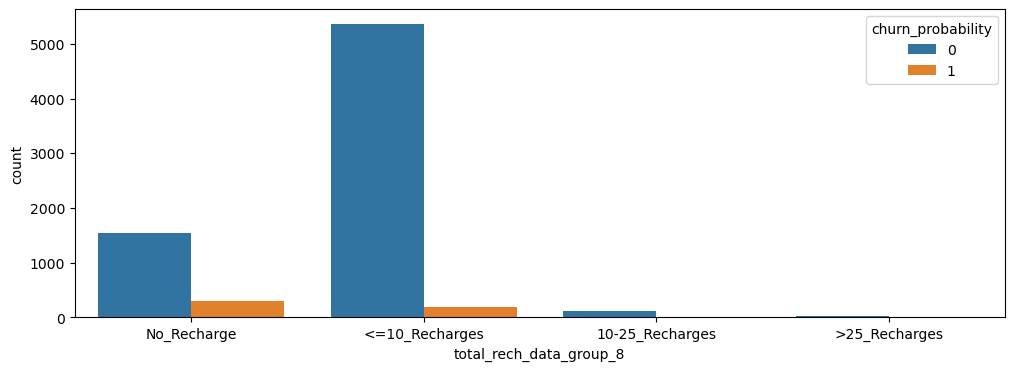

In [51]:
# Plotting the results

plt.figure(figsize=[12,4])
sns.countplot(data=data,x="total_rech_data_group_6",hue="churn_probability")
print("\t\t\t\t\tDistribution of total_rech_data_6 variable\n",data['total_rech_data_group_6'].value_counts())
plt.show()
print("\n\n")
plt.figure(figsize=[12,4])
sns.countplot(data=data,x="total_rech_data_group_7",hue="churn_probability")
print("\t\t\t\t\tDistribution of total_rech_data_6 variable\n",data['total_rech_data_group_7'].value_counts())
plt.show("\n\n")
print()
plt.figure(figsize=[12,4])
sns.countplot(data=data,x="total_rech_data_group_8",hue="churn_probability")
print("\t\t\t\t\tDistribution of total_rech_data_6 variable\n",data['total_rech_data_group_8'].value_counts())
plt.show()

#### <span style="color:blue">Observation :-</span>
As the number of total recharge data increases, the churn rate decreases clearly.

In [52]:
usage_2g_and_3g = data.columns[data.columns.str.contains('2g|3g',regex=True)]

In [53]:
data['total_usage_2g_and_3g'] = data[usage_2g_and_3g].sum(axis=1)
data['total_usage_2g_and_3g'].head()

15     808.32
27    3724.42
39    5137.10
45    2934.06
53    4164.86
Name: total_usage_2g_and_3g, dtype: float64

Text(0.5, 1.0, 'Plot between Churn and total usage  of 2g and 3g usage')

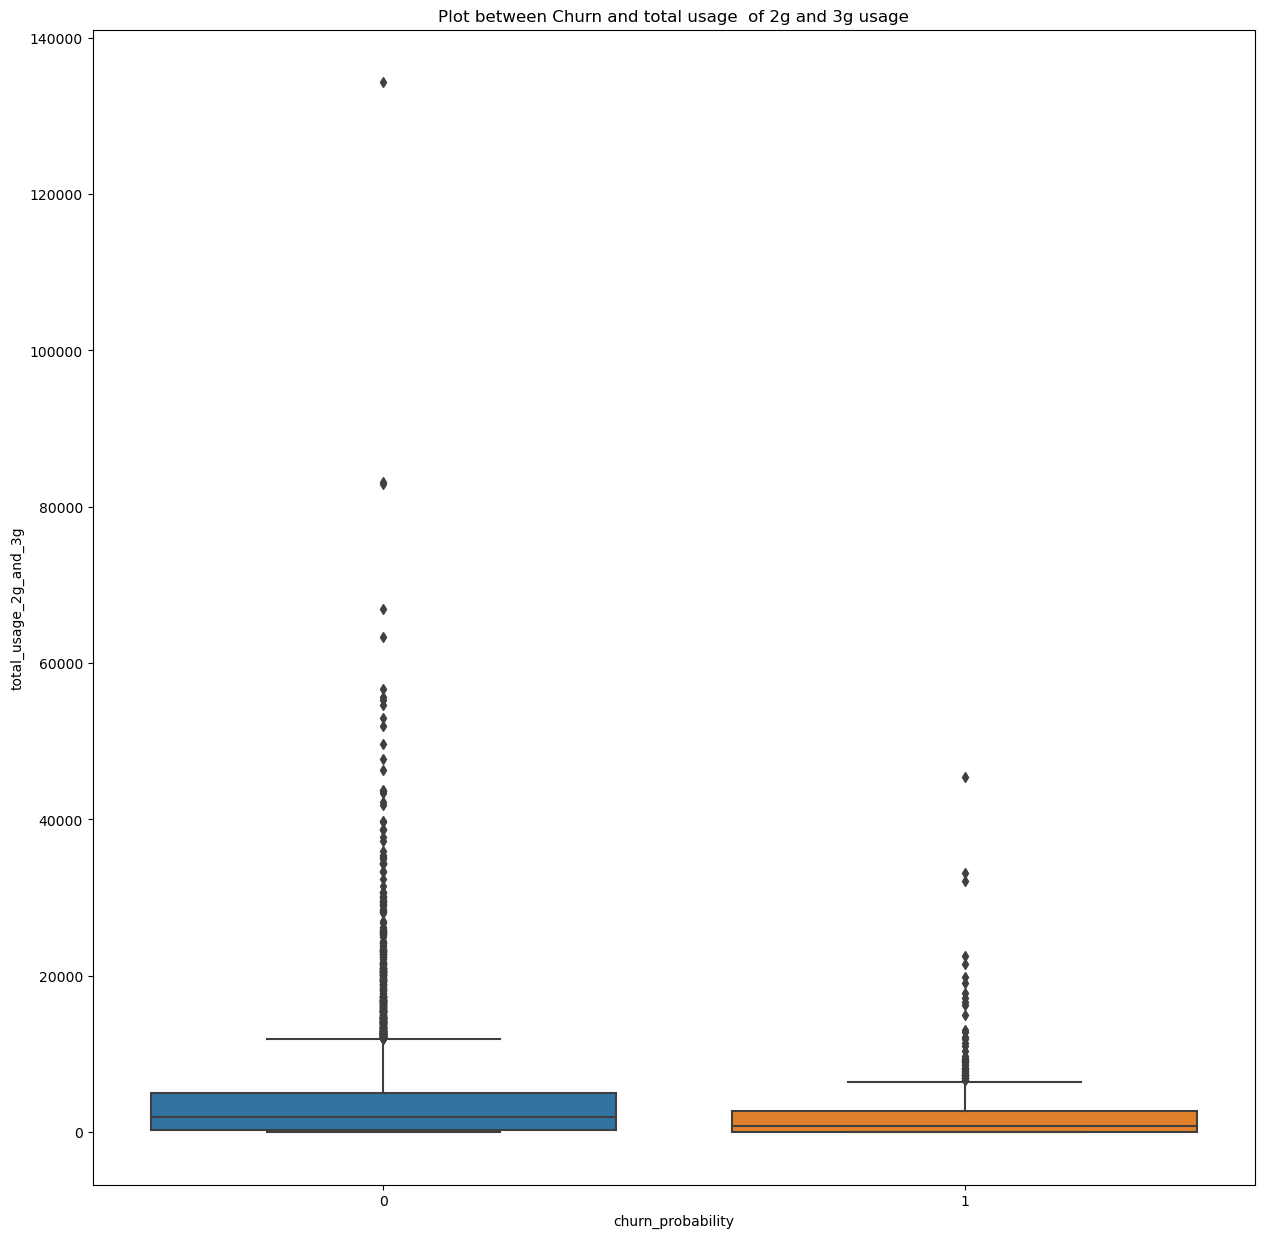

In [54]:
plt.figure(figsize=(15, 15))
# plt.subplot(2,3,1)
sns.boxplot(x = 'churn_probability', y = 'total_usage_2g_and_3g', data = data)
plt.title("Plot between Churn and total usage  of 2g and 3g usage")


#### <span style="color:blue">Observation :-</span>
As the total usage of 2g and 3g increases , the churn rate decreases clearly.

In [55]:

mou_og_cols6 = data.columns[data.columns.str.contains('.*_og_.*mou_6',regex=True)]
mou_og_cols6

Index(['roam_og_mou_6', 'loc_og_t2t_mou_6', 'loc_og_t2m_mou_6',
       'loc_og_t2f_mou_6', 'loc_og_t2c_mou_6', 'loc_og_mou_6',
       'std_og_t2t_mou_6', 'std_og_t2m_mou_6', 'std_og_t2f_mou_6',
       'spl_og_mou_6', 'total_og_mou_6'],
      dtype='object')

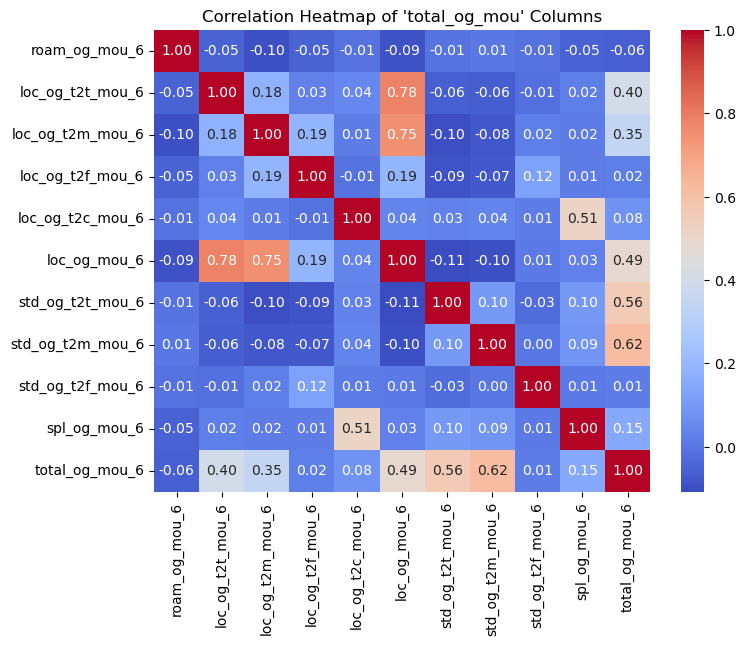

In [56]:
# Select the three columns of interest from the 'data' DataFrame
columns_of_interest = data[mou_og_cols6]

# Calculate the correlation matrix
correlation_matrix_tot_og_mou = columns_of_interest.corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_tot_og_mou, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of 'total_og_mou' Columns")
plt.show()

In [57]:
correlation_threshold = 0.75
# Find columns with high correlation
highly_correlated_columns = set()
for i in mou_og_cols6:
    for j in mou_og_cols6:
        if abs(correlation_matrix_tot_og_mou[i][j]) > correlation_threshold:
            print(j," --- ",correlation_matrix_tot_og_mou[i][j])
            highly_correlated_columns.add(j)
            
# 'highly_correlated_columns' now contains the names of columns with high correlation
print(highly_correlated_columns)

roam_og_mou_6  ---  1.0
loc_og_t2t_mou_6  ---  1.0
loc_og_mou_6  ---  0.7802120491458389
loc_og_t2m_mou_6  ---  1.0
loc_og_mou_6  ---  0.7512087137048377
loc_og_t2f_mou_6  ---  1.0
loc_og_t2c_mou_6  ---  1.0
loc_og_t2t_mou_6  ---  0.7802120491458389
loc_og_t2m_mou_6  ---  0.7512087137048377
loc_og_mou_6  ---  1.0
std_og_t2t_mou_6  ---  1.0
std_og_t2m_mou_6  ---  1.0
std_og_t2f_mou_6  ---  1.0
spl_og_mou_6  ---  1.0
total_og_mou_6  ---  1.0
{'loc_og_t2m_mou_6', 'total_og_mou_6', 'std_og_t2m_mou_6', 'loc_og_t2t_mou_6', 'std_og_t2f_mou_6', 'loc_og_t2c_mou_6', 'std_og_t2t_mou_6', 'spl_og_mou_6', 'loc_og_mou_6', 'loc_og_t2f_mou_6', 'roam_og_mou_6'}


In [ ]:
data.drop(['loc_og_mou_6', 'loc_og_t2t_mou_6'], axis=1)

#### <span style="color:blue">Observation :-</span>
It's evident that loc_og_mou_6 and loc_og_t2t_mou_6 exhibit notable correlations with other variables, suggesting the need for a thorough examination to mitigate potential multicollinearity concerns.

In [58]:
mou_og_cols7 = data.columns[data.columns.str.contains('.*_og_.*mou_7',regex=True)]
mou_og_cols7

Index(['roam_og_mou_7', 'loc_og_t2t_mou_7', 'loc_og_t2m_mou_7',
       'loc_og_t2f_mou_7', 'loc_og_t2c_mou_7', 'loc_og_mou_7',
       'std_og_t2t_mou_7', 'std_og_t2m_mou_7', 'std_og_t2f_mou_7',
       'spl_og_mou_7', 'total_og_mou_7'],
      dtype='object')

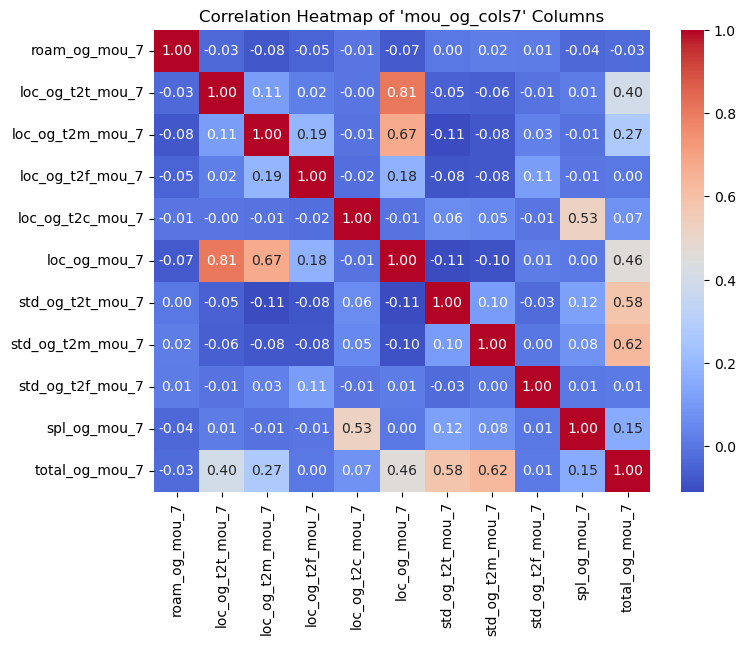

In [59]:
# Select the three columns of interest from the 'data' DataFrame
columns_of_interest = data[mou_og_cols7]

# Calculate the correlation matrix
correlation_matrix_mou_og_cols7 = columns_of_interest.corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_mou_og_cols7, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of 'mou_og_cols7' Columns")
plt.show()


In [ ]:
data.drop(['loc_og_mou_7', 'loc_og_t2t_mou_7'], axis=1)

#### <span style="color:blue">Observation :-</span>
It's evident that loc_og_mou_7 and loc_og_t2t_mou_7 exhibit notable correlations with other variables, suggesting the need for a thorough examination to mitigate potential multicollinearity concerns.

In [60]:
mou_og_cols7 = data.columns[data.columns.str.contains('.*_og_.*mou_8',regex=True)]
mou_og_cols7

Index(['roam_og_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8', 'loc_og_mou_8',
       'std_og_t2t_mou_8', 'std_og_t2m_mou_8', 'std_og_t2f_mou_8',
       'spl_og_mou_8', 'total_og_mou_8'],
      dtype='object')

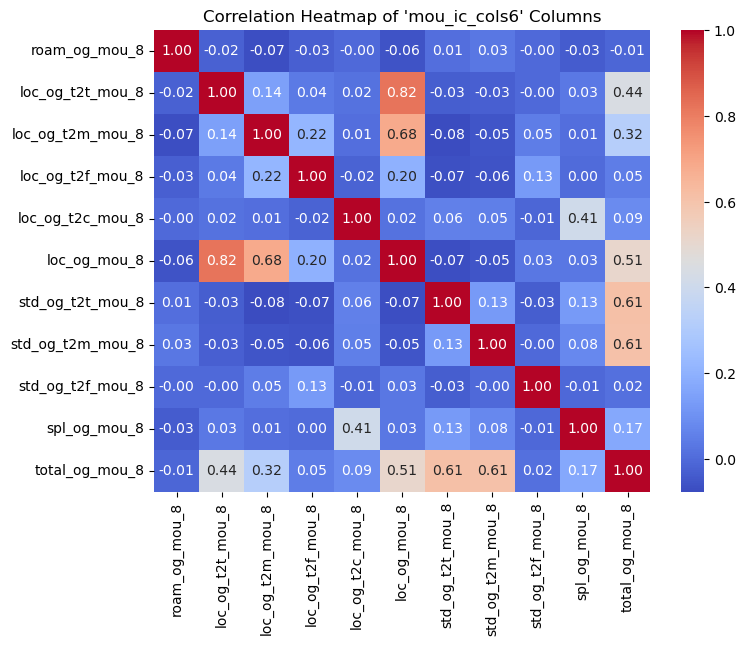

In [62]:
# Select the three columns of interest from the 'data' DataFrame
columns_of_interest_cols7 = data[mou_og_cols7]

# Calculate the correlation matrix
correlation_matrix_cols7 = columns_of_interest_cols7.corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_cols7, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of 'mou_ic_cols6' Columns")
plt.show()




In [ ]:
data.drop(['loc_og_mou_8', 'loc_og_t2t_mou_8'], axis=1)

In [63]:
mou_ic_cols6 = data.columns[data.columns.str.contains('.*_ic_.*mou_6',regex=True)]

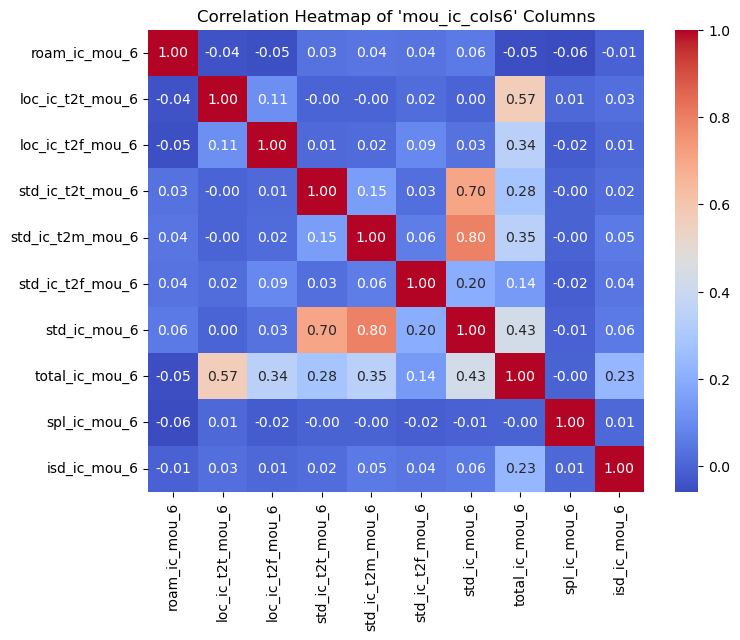

In [74]:
# Select the three columns of interest from the 'data' DataFrame
columns_of_interest_ic_cols6 = data[mou_ic_cols6]

# Calculate the correlation matrix
correlation_matrix_ic_cols6 = columns_of_interest_ic_cols6.corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of 'mou_ic_cols6' Columns")
plt.show()

In [75]:
correlation_matrix_ic_col6 = columns_of_interest_ic_cols6.corr()
correlation_threshold = 0.8
# Find columns with high correlation
highly_correlated_columns = set()
for i in mou_ic_cols6:
    for j in mou_ic_cols6:
        if abs(correlation_matrix_ic_col6[i][j]) > correlation_threshold:
            print(j," --- ",correlation_matrix_ic_col6[i][j])
            highly_correlated_columns.add(j)
            
# 'highly_correlated_columns' now contains the names of columns with high correlation
print(highly_correlated_columns)

roam_ic_mou_6  ---  1.0
loc_ic_t2t_mou_6  ---  1.0
loc_ic_t2f_mou_6  ---  1.0
std_ic_t2t_mou_6  ---  1.0
std_ic_t2m_mou_6  ---  1.0
std_ic_t2f_mou_6  ---  1.0
std_ic_mou_6  ---  1.0
total_ic_mou_6  ---  1.0
spl_ic_mou_6  ---  1.0
isd_ic_mou_6  ---  1.0
{'std_ic_t2t_mou_6', 'std_ic_mou_6', 'roam_ic_mou_6', 'std_ic_t2m_mou_6', 'spl_ic_mou_6', 'loc_ic_t2t_mou_6', 'total_ic_mou_6', 'std_ic_t2f_mou_6', 'loc_ic_t2f_mou_6', 'isd_ic_mou_6'}


In [ ]:
data.drop(['std_ic_mou_6', 'std_ic_t2m_mou_6'], axis=1)

#### <span style="color:blue">Observation :-</span>
It's evident that total_og_mou_6, std_og_mou_6, and loc_og_mou_6 exhibit notable correlations with other variables, suggesting the need for a thorough examination to mitigate potential multicollinearity concerns.

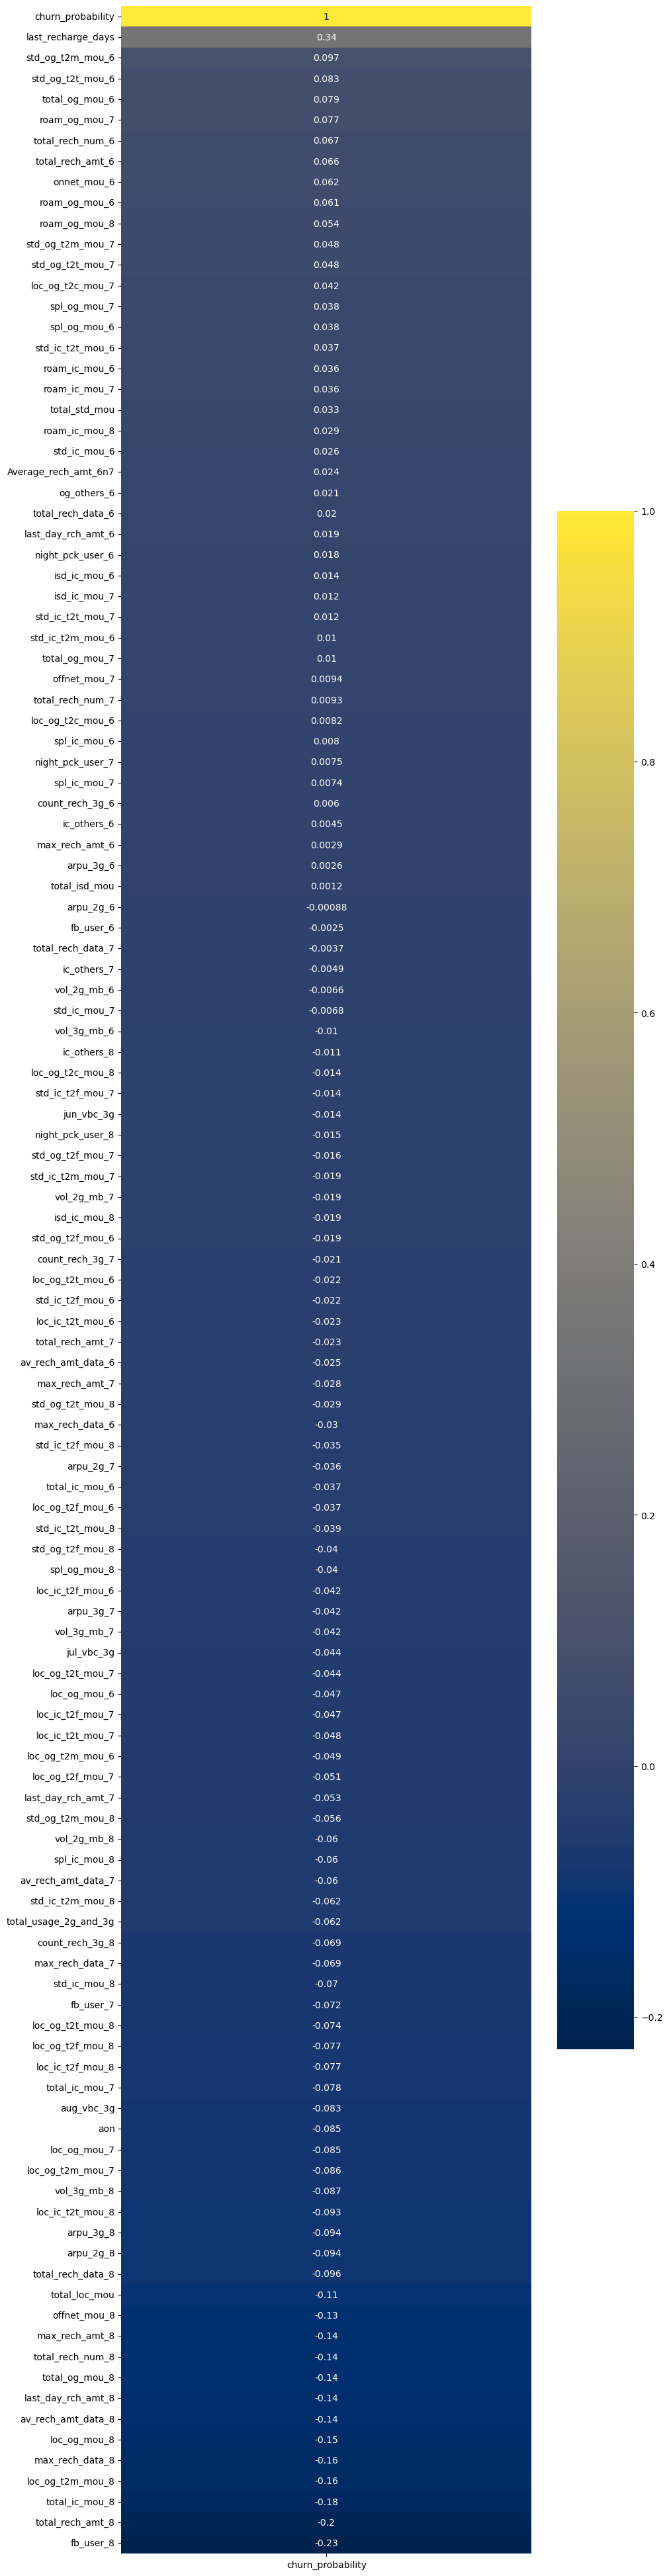

In [67]:
# Checking Correlation between target variable(Churn Probability) with the other variable in the dataset
plt.figure(figsize=(10,50))

numeric_data = data.select_dtypes(include=[np.number])
heatmap_churn = sns.heatmap(numeric_data.corr()[['churn_probability']].sort_values(ascending=False, by='churn_probability'), annot=True, cmap='cividis')

In [68]:
# Within our dataset, there is a column named 'aon' (Age on Network).


# We can generate additional variables to enhance our understanding of the data, particularly in relation to churn.

# Let's create a new variable called 'tenure' based on the number of months ('aon' divided by 30) and rounding to the nearest month.
data['tenure'] = (data['aon']/30).round(0)

# Now that we've derived the 'tenure' column from 'aon', we can safely drop it
data.drop('aon',axis=1, inplace=True)

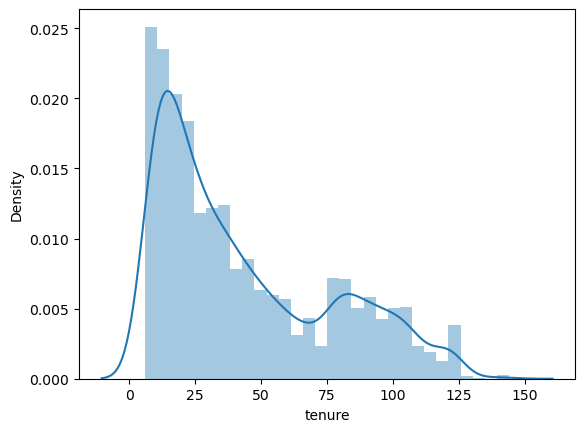

In [69]:
# To better visualize the distribution of the 'tenure' variable, we can plot it.

sns.distplot(data['tenure'],bins=30)
plt.show()

In [70]:
# created a range and divided it in different category
tn_range = [0, 6, 12, 24, 60, 61]
tn_label = [ '0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
data['tenure_range'] = pd.cut(data['tenure'], tn_range, labels=tn_label)
data['tenure_range'].head()

15    1-2 Yrs
27    1-2 Yrs
39    1-2 Yrs
45    2-5 Yrs
53    2-5 Yrs
Name: tenure_range, dtype: category
Categories (5, object): ['0-6 Months' < '6-12 Months' < '1-2 Yrs' < '2-5 Yrs' < '5 Yrs and above']

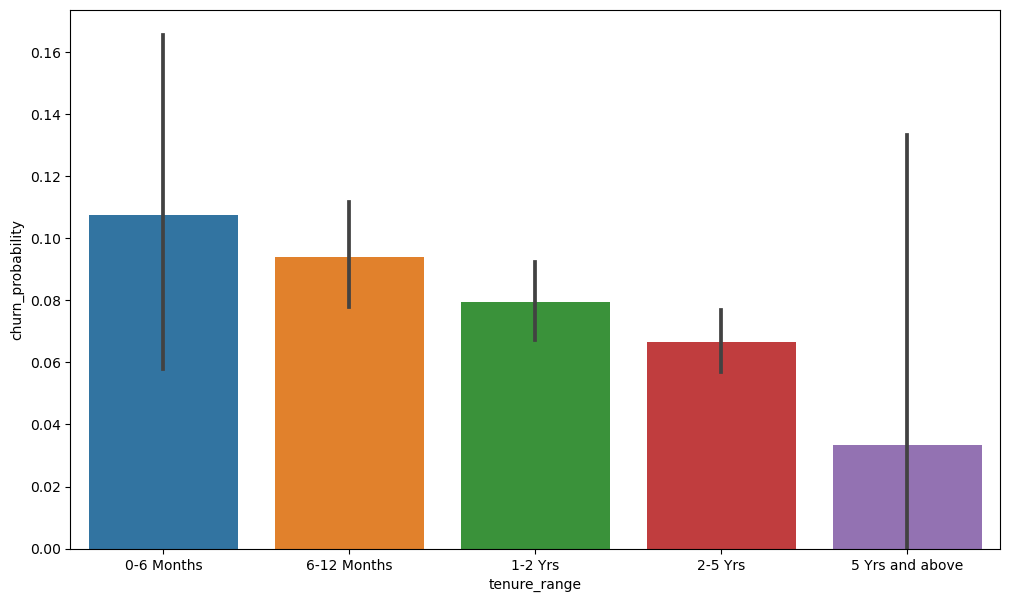

In [71]:
# Plotting a bar plot for tenure range
plt.figure(figsize=[12,7])
sns.barplot(x='tenure_range',y='churn_probability', data=data)
plt.show()

> <span style="color:blue">Observation</span> - People are churning more in 0-6 months of tenure

# 2. Create X, y

Lets create X and y datasets and skip "circle_id" since it has only 1 unique value

In [70]:
y = data.pop('churn_probability')
X = data

X.shape, y.shape

((7532, 134), (7532,))

Splitting train and test data to avoid any contamination of the test data

## 5. Preprocessing

### 5.1 Handling outliers

The box plots of these features show there a lot of outliers. These can be capped with k-sigma method.

In [71]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

In [72]:
X = X.apply(cap_outliers, axis=0)

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X)

TypeError: 'Categorical' with dtype category does not support reduction 'mean'

### 5.2 Feature scaling

Lets also scale the features by scaling them with Standard scaler (few other alternates are min-max scaling and Z-scaling).

In [ ]:
def scale_data(X):
    scaler = StandardScaler()
    X_col = X.columns
    X_scaled = scaler.fit_transform(X)
    X_scale_final = pd.DataFrame(X_scaled, columns=X_col)
    print("Scaling the data ....")
    return X_scale_final, scaler

### 5.3 Train Test split

In [ ]:
def train_test_data(X,Y,train_size=0.7,test_size=0.3):    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, train_size=train_size, random_state=42)
    return X_train, X_test, y_train, y_test

### 5.4 Class imbalance fix (SMOTE)

In [ ]:
def resampling_data(X_train, y_train) :
   
    print("Shape of train datatset before : "+str(X_train.shape))
    print("Percenatge of Churned customer data : "+str(round(100*y_train.sum()/len(y_train),2)))
    print("Applying SMOTE to normalize imbalance ....")

    #Initializing SMOTE: Synthetic Minority Over-sampling Technique
    # using this as data is skewed 
    smote = SMOTE(random_state=42)
    X_tr,y_tr = smote.fit_resample(X_train,y_train)
    print("Shape of train datatset after SMOTE : "+str(X_tr.shape))
    return X_tr,y_tr

### 5.5 PCA implementation

In [ ]:
def no_of_component_through_pca(X_train) :
    pca = PCA(0.9)
    df_train_pca = pca.fit_transform(X_train)
    return df_train_pca.shape[1]
    

In [ ]:
def incremental_pca(X_train, X_test, feature_number):
    pca = IncrementalPCA(n_components=feature_number)    
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca, pca

### 5.6 process data before Model creation

In [ ]:
X_scaled, scaler = scale_data(X)
X_train, X_test, y_train, y_test = train_test_data(X_scaled, y)
X_train_resample, y_train_resample = resampling_data(X_train, y_train)
no_of_component = no_of_component_through_pca(X_train_resample)
X_train_pca, X_test_pca, pca = incremental_pca(X_train_resample, X_test, no_of_component)
X_train_pca.shape

# Model Creation

### Model Matrics summary

In [ ]:
def print_model_metrics(y_test,y_pred,model_name):
    print(model_name+" Model Stats Scores Summary : ")
    cp = confusion_matrix(y_test,y_pred)
        
    accuracy = round(accuracy_score(y_test,y_pred),2)
    recall = round(recall_score(y_test,y_pred),2)
    precision = round(precision_score(y_test,y_pred),2)
    auc = round(roc_auc_score(y_test,y_pred),2)
    f1 = round(f1_score(y_test,y_pred),2)

    data = [[model_name,accuracy,recall,precision,auc,f1]] 
    df = pd.DataFrame(data, columns = ['Model', 'Accuracy','Precision','Recall','AUC','F1'])
    return df 

## 6.1. Logistic Regression with PCA

In [ ]:
lr = LogisticRegression(random_state=42)

model_train = lr.fit(X_train_pca, y_train_resample)
pred_probs_train = model_train.predict_proba(X_train_pca)[:,1]
print("Linear Regression Accurancy train : "+"{:2.2}".format(metrics.roc_auc_score(y_train_resample, pred_probs_train)))

pred_probs_test = model_train.predict_proba(X_test_pca)[:,1]
print("Linear Regression Accurancy test : "+"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test)))

## 6.2. Random Forest

### GridSearch to fetch best parameters for Random forest

In [ ]:
rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')
param_grid = {
    'n_estimators': [20, 30, 50, 70], 
    'max_depth': [20, 30, 40],
    'min_samples_leaf':[100,200,300]
}
# Create GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model to the data
grid_search.fit(X_train_pca, y_train_resample)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Use the best model to make predictions
best_model = grid_search.best_estimator_

In [ ]:
print('Best parameters')
best_params

In [ ]:
rfc = RandomForestClassifier(random_state=42, max_depth=best_params['max_depth'], n_estimators=best_params['n_estimators'], min_samples_leaf= best_params['min_samples_leaf'] )
rfc.fit(X_train_pca,y_train_resample)

In [ ]:
result = pd.DataFrame()

In [ ]:
train_predictions = rfc.predict(X_train_pca)
train = print_model_metrics(y_train_resample,train_predictions,"RandomForest Train")
result = train
train

In [ ]:
test_predictions = rfc.predict(X_test_pca)
test =  print_model_metrics(y_test,test_predictions,"RandomForest Test")
result = pd.concat([result, test], ignore_index=True)
test

In [ ]:
result

## 6.3. XGBoost

In [ ]:
# hyperparameter tuning with XGBoost

# creating a KFold object 
folds = 5

# specify range of hyperparameters
param_grid = {'learning_rate': [0.3,0.4,0.5], 
             'subsample': [0.5,0.6,0.7]}          


# specify model
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'accuracy', # accuracy
                        cv = folds, 
                        n_jobs = -1,
                        verbose = 1,
                        return_train_score=True) 

In [ ]:
model_cv.fit(X_train_pca, y_train_resample)  

In [ ]:
print('Best parameters')
model_cv.best_params_

In [ ]:
model = XGBClassifier(random_state=42, learning_rate=0.3, subsample=0.5)
model.fit(X_train_pca, y_train_resample)

In [ ]:
y_pred_train = model.predict(X_train_pca)
train = print_model_metrics(y_train_resample, y_pred_train ,'XGBoost Train')
result = pd.concat([result, train], ignore_index=True)
train

In [ ]:

y_pred_test = model.predict(X_test_pca)
test = print_model_metrics(y_test, y_pred_test ,'XGBoost Test')
result = pd.concat([result, test], ignore_index=True)
test

In [ ]:
col = list(X_scaled.columns)
df_pca = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'PC3':pca.components_[2],'Feature':col})
df_pca.head(15)

In [ ]:
result

# Conclusion
- Since XGBboost is performing better on train data hence same would be used on test data


# 7. Creating submission file

In [ ]:
unseen_new = unseen.set_index('id')[X_train.columns]

In [ ]:
# Impute missing values
imp = SimpleImputer(strategy='constant', fill_value=0)
X_unseen_imputed = imp.fit_transform(unseen_new)
X_unseen_scaled = scaler.transform(X_unseen_imputed)
X_unseen_pca = pca.transform(X_unseen_scaled)
X_unseen_pca.shape

In [ ]:
unseen['churn_probability'] = model.predict(X_unseen_pca)
output = unseen[['id','churn_probability']]
output.head()

In [ ]:
output.to_csv('submission.csv',index=False)

In [ ]:
output['churn_probability'].value_counts()